<a href="https://colab.research.google.com/github/CptK1ng/dmc2019/blob/alexander_dev/notebooks/semisupervised_learning_pseudo_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi Supervised Learning using Pseudo Labeling
by Alexander

inspired by [this blog post](https://towardsdatascience.com/simple-explanation-of-semi-supervised-learning-and-pseudo-labeling-c2218e8c769b).

in this version of the notebook (see commit history for older ones) we only use high-propability-predictions to extend our training set.

In [0]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import time as time
%matplotlib inline

Download our custom Dataset splits and the unlabeled Test Set:

In [2]:
!wget -nc -q --show-progress https://www.dropbox.com/s/6m8iq9ogpzmu7vx/train_new.csv?dl=1 -O train_new.csv
!wget -nc -q --show-progress https://www.dropbox.com/s/tjpkc45oqn3uv8s/val_new.csv?dl=1 -O val_new.csv
!wget -nc -q --show-progress https://www.dropbox.com/s/hbd6nzgwlnevu4x/test.csv?dl=1 -O test.csv

train_new.csv       100%[===================>] 104.09K  --.-KB/s    in 0.03s   
val_new.csv         100%[===================>]  25.96K  --.-KB/s    in 0.01s   
test.csv            100%[===================>]  32.04M  15.2MB/s    in 2.1s    


Import Data:

In [3]:
df_train_original = pd.read_csv("train_new.csv", sep="|")
df_val_original = pd.read_csv("val_new.csv", sep="|")
df_test_original = pd.read_csv("test.csv", sep="|")
df_train_original.head(2)

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,828,66.56,7,4,3,0.007246,0.080386,1.166667,0
1,1,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0


## Feature Engineering

In [4]:
def prepareData(df):
  df = df.copy()
  df['totalLineItems'] = df['scannedLineItemsPerSecond'] * df['totalScanTimeInSeconds'] #nur of scanned products
  return df

df_train = prepareData(df_train_original)
df_val = prepareData(df_val_original)
df_test = prepareData(df_test_original)

df_train.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,totalLineItems
0,4,828,66.56,7,4,3,0.007246,0.080386,1.166667,0,6.0
1,1,1612,31.34,2,4,3,0.008685,0.019442,0.142857,0,14.0
2,3,848,52.37,2,4,0,0.022406,0.061757,0.105263,0,19.0
3,1,321,76.03,8,7,2,0.071651,0.236854,0.347826,0,23.0
4,1,660,6.06,3,7,1,0.027273,0.009182,0.166667,0,18.0


## Split X and Y

In [5]:
# Splitting the final dataset into internal training and testing datasets
df_train_X = df_train.drop('fraud', axis=1)
df_train_y = df_train['fraud']
df_val_X = df_val.drop('fraud', axis=1)
df_val_y = df_val['fraud']
df_test_X = df_test.copy()
# df_test_y will be predicted by classificator

X_train, X_val, X_test, y_train, y_val = df_train_X.values, df_val_X.values, df_test_X, df_train_y.values, df_val_y.values
print("Shapes",X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape)

Shapes (1503, 10) (376, 10) (498121, 10) (1503,) (376,)


## Simple Classificator


In [0]:
def score_function(y_true, y_pred):
  dmc = np.sum(metrics.confusion_matrix(y_true, y_pred)*np.array([[0, -25],[ -5, 5]])) #sklearn gives [[tn,fp],[fn,tp]]
  return (0 if all(y_pred == 0) else metrics.fbeta_score(y_true, y_pred, beta=2),
          dmc, 
          dmc/len(y_pred), #comparable relative score, the higher the better.
          metrics.confusion_matrix(y_true, y_pred).tolist())

##  Classify labels for validation set on training set

In [7]:
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=500, algorithm='SAMME', random_state=1)

# Fitting the model and printing the accuracy score
classifier_adb.fit(X_train, y_train)
print("AdaBoost", "\t", score_function(y_val, classifier_adb.predict(X_val)) )

AdaBoost 	 (0.8771929824561403, 35, 0.09308510638297872, [[351, 2], [3, 20]])


### Classify labels (and get the prediction accuracy) for testset on training set

In [8]:
y_test = classifier_adb.predict(X_test) # predictions
y_test_proba = classifier_adb.predict_proba(X_test)
print(y_test[1:500], "\nproba\n", y_test_proba[1:10])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

We combine them into a dataframe for easier filtering

In [9]:
df_test_y = pd.DataFrame(y_test_proba, columns=["fraud_0_prob", "fraud_1_prob"])
df_test_y["fraud"] = y_test
df_test_y["pred_prob"] = df_test_y[["fraud_0_prob", "fraud_1_prob"]].max(axis=1) # take the prob that lead to the classification
df_test_y.head(5)

,fraud_0_prob,fraud_1_prob,fraud,pred_prob
0,0.645118,0.354882,0,0.645118
1,0.613990,0.386010,0,0.613990
2,0.626261,0.373739,0,0.626261
3,0.654758,0.345242,0,0.654758
4,0.664540,0.335460,0,0.664540


now take those entries with high certainity / pred_prob and combine the Train and high-prob-predicted-Test Set for new combined Test Set

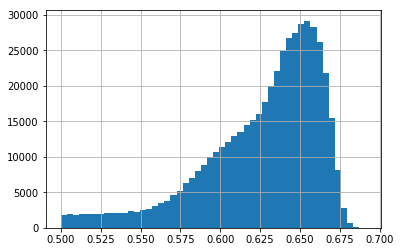

In [10]:
df_test_y["pred_prob"].hist(bins=50)

In [11]:
threshold = 0.677 # the lower this number is the higher the amount of test data we add to our train set will be.


def get_train_new(threshold):
  df_test_y_new = df_test_y[df_test_y.pred_prob > threshold]
  # print("size of labeled test set with high proba:", len(df_test_y_new))

  # append safe predictions y to their X
  df_test_new = df_test_y_new[["fraud"]].join(df_test_X)
  df_test_new.head(3)

  # append the high-prob-labeled test set to our train set
  df_train_new = pd.concat([df_train,df_test_new], ignore_index=True, sort=False)
  # print("size of new train:", len(df_train_new))

  # convert dataframes to classifiable python lists
  df_train_new_X = df_train_new.drop('fraud', axis=1)
  df_train_new_y = df_train_new['fraud']
  X_train_new, y_train_new = df_train_new_X.values, df_train_new_y.values
  
  print("threshold of ",threshold," results in",len(df_test_y_new),"high-prob-predictions and a new train set of size ",len(df_train_new))
  
  return X_train_new, y_train_new

X_train_new, y_train_new = get_train_new(threshold)

print("Shapes",X_train_new.shape, y_train_new.shape)

threshold of  0.677  results in 2236 high-prob-predictions and a new train set of size  3739
Shapes (3739, 10) (3739,)


##  Classify labels for validation set on training and part of testing set

In [12]:
# Now test inference with semi supervised learned new training dataset
    
classifier_adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=500, algorithm='SAMME', random_state=1)
classifier_adb.fit(X_train_new, y_train_new)  

print("AdaBoost", "\t", score_function(y_val, classifier_adb.predict(X_val)) )

AdaBoost 	 (0.8482142857142857, 50, 0.13297872340425532, [[352, 1], [4, 19]])


As we can see this method has a pretty good accuracy. 

We can play around with different thresholds now.

threshold of  0.667  results in 32598 high-prob-predictions and a new train set of size  34101
threshold of  0.668  results in 27364 high-prob-predictions and a new train set of size  28867
threshold of  0.669  results in 22649 high-prob-predictions and a new train set of size  24152
threshold of  0.67  results in 18410 high-prob-predictions and a new train set of size  19913
threshold of  0.671  results in 14584 high-prob-predictions and a new train set of size  16087
threshold of  0.672  results in 11250 high-prob-predictions and a new train set of size  12753
threshold of  0.673  results in 8353 high-prob-predictions and a new train set of size  9856
threshold of  0.674  results in 6198 high-prob-predictions and a new train set of size  7701
threshold of  0.675  results in 4522 high-prob-predictions and a new train set of size  6025
threshold of  0.676  results in 3266 high-prob-predictions and a new train set of size  4769
threshold of  0.677  results in 2236 high-prob-predictions 

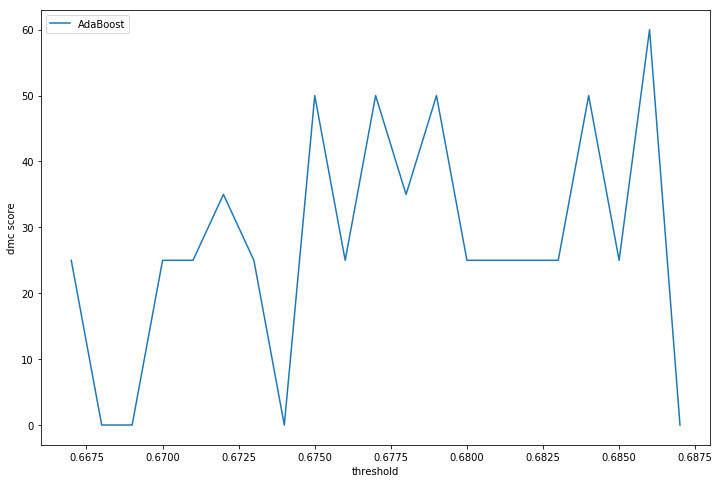

Duration:  181.90587236699957


In [0]:
stepsize = 0.001
resolution = 10 # will go 10 steps to left and right of threshhold

start_plot = time.monotonic()
dmc_score = []

for i in np.arange(threshold-resolution*stepsize,threshold+resolution*stepsize,stepsize):
  classifier_adb.fit(*get_train_new(i))  
  dmc_score.append(score_function(y_val, classifier_adb.predict(X_val))[1])

plt.figure(figsize=(12, 8))
plt.xlabel('threshold')
plt.ylabel('dmc score')
plt.plot(np.arange(threshold-resolution*stepsize,threshold+resolution*stepsize,stepsize), dmc_score, label="AdaBoost")
plt.legend()
plt.show()
duration_plot = time.monotonic() - start_plot
print("Duration: ", duration_plot)

We can set the threshold to the percentage that should lead to improved results (as calculated [here](https://github.com/CptK1ng/dmc2019/issues/9#issuecomment-485343221)):

In [13]:
classifier_adb.fit(*get_train_new(0.71))
print("AdaBoost", "\t", score_function(y_val, classifier_adb.predict(X_val)) )

threshold of  0.71  results in 0 high-prob-predictions and a new train set of size  1503
AdaBoost 	 (0.8771929824561403, 35, 0.09308510638297872, [[351, 2], [3, 20]])


unfortunately, there are no test set predictions with such high accuracy, and therefore the new train set size (1503) is equal to the original train size.

we can conclude that this method does not improve the final DMC score if we do not find a better classificator which has a higher prediction certainity (>0.71) on the test set rows.